In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Transition rate matrix for the network
Lambda = np.array([
    [  0, 2/5, 1/5,   0,   0],
    [  0,   0, 3/4, 1/4,   0],
    [1/2,   0,   0, 1/3,   0],
    [  0,   0, 1/3,   0, 2/3],
    [  0, 1/2,   0, 1/3,   0]
])


### ___ Helper Functions ___

In [18]:
def normalize_matrix(matrix):
    """
    Normalizes a matrix row-wise, handling rows with a sum of zero.
    
    Parameters:
        matrix (numpy.ndarray): Input matrix.
        
    Returns:
        numpy.ndarray: Row-normalized matrix with zero rows handled.
    """
    row_sums = matrix.sum(axis=1)
    normalized_matrix = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        if row_sums[i] > 0:
            normalized_matrix[i] = matrix[i] / row_sums[i]
    return normalized_matrix


In [19]:
def generate_exponential_time(rate, n_particles=1):
    """
    Generates a time from an exponential distribution based on the given rate.
    
    Parameters:
        rate (float): Rate parameter of the exponential distribution.
        
    Returns:
        float: Generated exponential time.
    """
    np.random.seed(seed=42)
    if rate <= 0:
        return float('inf')  # For zero or negative rates
    return np.random.exponential(1 / (n_particles * rate))


In [20]:
def french_degroot_dynamics(P, x0, steps=100):
    x = x0
    trajectories = []
    trajectories.append(x0)
    for i in range(steps):
        x = P @ x
        trajectories.append(x)
        
    return x, trajectories

In [21]:
def simulate_random_walk(origin, destination=None, Lambda=None, n_simulations=10000,seed=42):
    """
    Simulates a random walk on a graph described by the transition rate matrix.

    Parameters:
        origin (int): Starting node index.
        destination (int, optional): Target node index. If None, computes return times to origin.
        Lambda (np.ndarray): Transition rate matrix.
        n_simulations (int): Number of simulations to perform.

    Returns:
        float: Average hitting time (or return time) based on the type of computation.
        list: List of visited nodes and cumulative times for each simulation.
    """
    if Lambda is None:
        raise ValueError("Lambda (transition rate matrix) must be provided.")
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    # Compute transition probabilities and exit rates
    w_star = Lambda.sum(axis=1)  # Exit rates for each node
    P = np.zeros_like(Lambda)
    for i in range(Lambda.shape[0]):
        if w_star[i] > 0:
            P[i] = Lambda[i] / w_star[i]  # Normalize non-zero rows to get probabilities


    # Array to store hitting or return times
    times = np.zeros(n_simulations, dtype=float)
    all_visited_nodes = []  # To store visited nodes for each simulation
    
    for sim in range(n_simulations):
        pos = origin  # Current position of the particle
        total_time = 0  # Total time for the walk
        visited_nodes = [(origin, 0)]  # Reset for each simulation

        while True:
            # Generate transition time for the current node
            if w_star[pos] > 0:
                t_next = -np.log(np.random.rand()) / w_star[pos]
            else:
                t_next = float('inf')  # No outgoing transitions, particle is stuck
            total_time += t_next

            # Choose the next node based on the transition probabilities
            if w_star[pos] > 0:
                next_node = np.random.choice(len(P[pos]), p=P[pos])
                visited_nodes.append((next_node, total_time))
            else:
                break  # No transitions possible

            # Check for stopping conditions
            if destination is not None and next_node == destination:
                # Hitting time: Stop when destination is reached
                break
            if destination is None and next_node == origin:
                # Return time: Stop when returning to the origin
                break

            # Update position
            pos = next_node

        # Record the total hitting/return time for this simulation
        times[sim] = total_time
        all_visited_nodes.append(visited_nodes)  # Store visited nodes for this simulation
        visited_nodes = []  # Reset for the next simulation

    # Calculate and return the average hitting/return time
    avg_time = np.mean(times)
    return avg_time, all_visited_nodes


In [22]:
def calculate_return_times(visited_nodes, transition_times, target_node):
    """
    Calculate return times to a specific node in the visited nodes sequence.
    
    Parameters:
        visited_nodes (list): List of visited nodes.
        transition_times (list): List of time intervals between transitions.
        target_node (int): Node to calculate return times for.
    
    Returns:
        float: Average return time to the target node.
    """
    return_times = []
    current_time = 0

    for i in range(1, len(visited_nodes)):
        if visited_nodes[i] == target_node:
            return_times.append(current_time)
            current_time = 0
        if i < len(transition_times):
            current_time += transition_times[i - 1]

    return np.mean(return_times) if return_times else float('inf')

In [23]:
def modify_edges(rate_matrix, edges_to_remove):
    """
    Modifies the rate matrix by removing specified edges.

    Parameters:
        rate_matrix (numpy.ndarray): Original transition rate matrix.
        edges_to_remove (list of tuples): List of edges to remove, each as (from_node, to_node).

    Returns:
        numpy.ndarray: Modified transition rate matrix.
    """
    # Make a copy to avoid modifying the original matrix
    modified_matrix = rate_matrix.copy()
    
    # Iterate through the edges to remove and set their weights to 0
    for from_node, to_node in edges_to_remove:
        modified_matrix[from_node, to_node] = 0
    
    return modified_matrix


---
---
---

 #### 1-a: Simulate and Calculate Average Return Time to Node 'a'

In [24]:
start_node = 1  # Node 'a'
n_simulations = 1000

# Simulate random walk
average_return_time_to_a, _ = simulate_random_walk(origin=start_node, destination=None, Lambda=Lambda, n_simulations=n_simulations)

print("Average return time to node 'a':", average_return_time_to_a)


Average return time to node 'a': 6.1100728222231355


 #### 1-b: Theoretical Return Time for Node 'a'

In [25]:
num_nodes = Lambda.shape[0]
Q = Lambda.copy()
np.fill_diagonal(Q, -np.sum(Q, axis=1))

A = Q.T
A[-1] = np.ones(num_nodes)
b = np.zeros(num_nodes)
b[-1] = 1


stationary_distribution = np.linalg.solve(A, b)
theoretical_return_time_a = 1 / stationary_distribution[start_node]
print("Theoretical return time to node 'a':", theoretical_return_time_a)
print("Error simulation", abs(theoretical_return_time_a - average_return_time_to_a))
stationary_distribution, stationary_distribution.sum()


Theoretical return time to node 'a': 6.058823529411764
Error simulation 0.051249292811371916


(array([0.23058252, 0.16504854, 0.27669903, 0.18203883, 0.14563107]), 1.0)

#### 1-c: Simulate Hitting Time from 'o' to 'd'

In [26]:
start_node = 0  # Node 'o'
target_node = 4  # Node 'd'
steps = 10000   # Number of simulation steps

# Simulate random walk
simulated_hitting_time_o_to_d, _ = simulate_random_walk(origin=start_node, destination=target_node, Lambda=Lambda, n_simulations=n_simulations)

print("Average hitting time from 'o' to node 'd':", simulated_hitting_time_o_to_d)


Average hitting time from 'o' to node 'd': 10.866962891493504


#### 1-d: Theoretical Hitting Time from 'o' to 'd'

In [27]:
# h_R = (I - P_hat) * 1/w_hat
w_hat = Lambda.sum(axis=1)[:-1]

# Compute P_hat (restricted normalized transition probabilities)
P_hat = Lambda[:-1, :-1] / w_hat[:, None]

# Identity matrix for solving (I - P_hat)
I = np.eye(P_hat.shape[0])

# Compute b = 1 / w_hat (inverse exit rates for R)
b = 1 / w_hat

# Solve the linear system: (I - P_hat) * h_R = b
h_R = np.linalg.solve(I - P_hat, b)

# Extend h_R to include the hitting time for the target node
hitting_times = np.zeros(Lambda.shape[0])
hitting_times[:-1] = h_R  # Hitting times for nodes in R
hitting_times[-1] = 0     # Hitting time for target node (d) is 0

# Output the hitting time from the starting node 'o' (index 0)
theoretical_hitting_time_o_to_d = hitting_times[0]
print("Theoretical hitting time from 'o' to 'd':", theoretical_hitting_time_o_to_d)
print("Error simulation", abs(theoretical_hitting_time_o_to_d - simulated_hitting_time_o_to_d))


Theoretical hitting time from 'o' to 'd': 10.766666666666666
Error simulation 0.1002962248268382


#### 1-e: French-DeGroot Dynamics and Consensus

In [28]:
# Initial condition
x0 = [15, 30, 50, 30, 15]
steps = 40
P = normalize_matrix(Lambda)
num_nodes = len(x0)

final_opinions, trajectories = french_degroot_dynamics(P, x0, steps)
trajectories = np.array(trajectories)
# Check for consensus
print("Final state:", final_opinions)


Final state: [30.85507214 30.85507034 30.85507794 30.85506271 30.85507994]


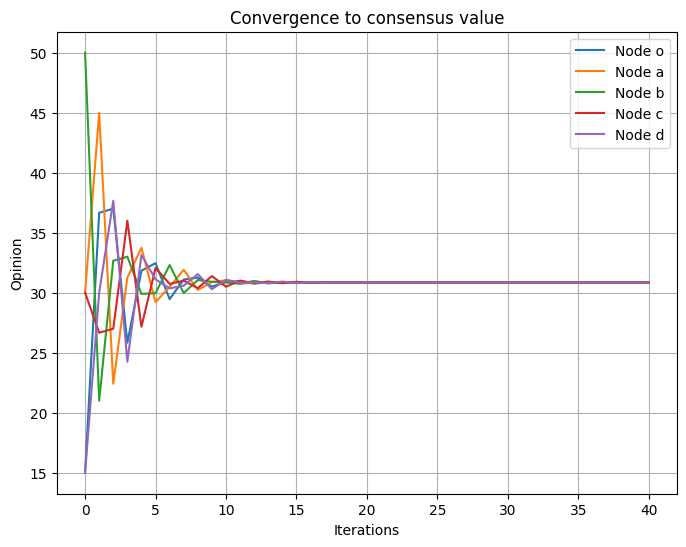

In [29]:
# Plotting
plt.figure(figsize=(8, 6))
node_labels = ['Node o', 'Node a', 'Node b', 'Node c', 'Node d']
for node in range(trajectories.shape[1]):
    
    plt.plot(trajectories[:, node], label=node_labels[node])

plt.title("Convergence to consensus value")
plt.xlabel("Iterations")
plt.ylabel("Opinion")
plt.legend()
plt.grid(True)
plt.savefig('convergence_plot.jpg')
plt.show()

#### 1-f: Variance of Consensus Value

In [30]:
# Step 1: Compute the normalized transition matrix P
w = Lambda.sum(axis=1)  # Row sums
P = Lambda / w[:, None]  # Normalize rows to get a stochastic matrix

In [31]:
# Step 2: Compute stationary distribution (pi)
values, vectors = np.linalg.eig(P.T)  # Transpose for left eigenvector

# Find the eigenvector corresponding to eigenvalue 1
stationary = vectors[:, np.isclose(values, 1)]
stationary = stationary[:, 0].real                       # Extract eigenvector
stationary = stationary / stationary.sum()          # Normalize


pi = stationary

print("Theoretical Stationary Distribution (pi):", pi)

Theoretical Stationary Distribution (pi): [0.16521739 0.19710145 0.27536232 0.2173913  0.14492754]


In [32]:
# Step 3: Compute the variance of the consensus value
# Initial variances for nodes: o, a, b, c, d
variances = np.array([1, 2, 2, 2, 1])

# Theoretical variance of the consensus value
theoretical_variance = np.sum((pi**2) * variances)
print("Theoretical Variance of the Consensus Value:", theoretical_variance)

Theoretical Variance of the Consensus Value: 0.372165511447175


In [33]:
# Step 4: Simulate French-DeGroot dynamics
# Compute empirical variance of consensus value over multiple trials
num_trials = 10000
consensus_values = []

for _ in range(num_trials):
    x0 = np.random.normal(0, np.sqrt(variances))  # Random initial opinions
    final_opinions, _ = french_degroot_dynamics(P, x0)
    consensus_values.append(final_opinions)

# Empirical variance of consensus values
empirical_variance = np.var(consensus_values)
print("Empirical Variance of the Consensus Value (Over Multiple Trials):", empirical_variance)
print("Error: ", np.abs(empirical_variance - theoretical_variance))


Empirical Variance of the Consensus Value (Over Multiple Trials): 0.3742721916239558
Error:  0.002106680176780784


#### 1-g: Dynamics with Edges Removed

In [34]:
# Edges to remove
edges_to_remove = [(4, 1), (4, 3), (1, 3), (2, 3)]  # (d, a), (d, c), (a, c), (b, c)

# Modify the rate matrix
modified_matrix_g = modify_edges(Lambda, edges_to_remove)
P = normalize_matrix(modified_matrix_g)
num_nodes = len(x0)

np.random.seed(seed=42)
# Initial condition
x0 = np.random.rand(5)
steps = 100

# Simulate dynamics
final_opinions_g, _ = french_degroot_dynamics(P=P, x0=x0, steps=steps)

print("Final state with edges removed:\n"+ str(final_opinions_g))

Final state with edges removed:
[0.65262885 0.65262885 0.65262885 0.21754295 0.        ]


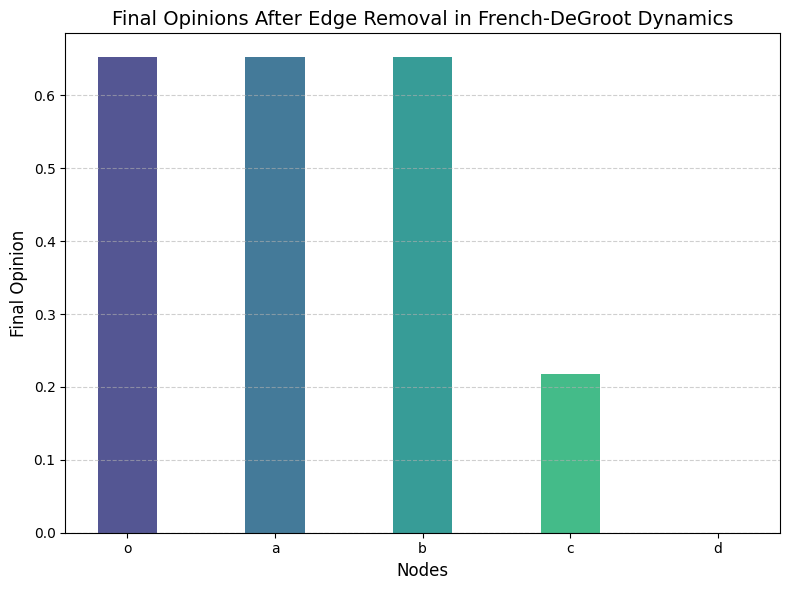

In [35]:
# plotting the final opinions after edge removal
nodes = ['o', 'a', 'b', 'c', 'd']


# Define a colormap for better visual distinction
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(nodes)))

plt.figure(figsize=(8, 6))
plt.bar(nodes, final_opinions_g, color=colors, width=0.4, alpha=0.9)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Final Opinion", fontsize=12)
plt.title("Final Opinions After Edge Removal in French-DeGroot Dynamics", fontsize=14)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('final_opinions_after_edge_removal_g.jpg',)
plt.show()


#### 1-h: Dynamics with Different Edges Removed

In [36]:
# Edges to remove
edges_to_remove_h = [(2, 0), (4, 1)]  # (b, o) and (d, a)

# Modify the rate matrix
modified_matrix_h = modify_edges(Lambda, edges_to_remove_h)
P = normalize_matrix(modified_matrix_h)
# Initial condition
np.random.seed(seed=42)
x0 = np.random.rand(5)
steps = 100

# Simulate dynamics
final_opinions_h, _ = french_degroot_dynamics(P=P, x0=x0, steps=steps)


print("Final state with edges removed:\n"+ str(final_opinions_h))
print(np.var(final_opinions))


Final state with edges removed:
[0.47333445 0.53599647 0.34801041 0.59865848 0.34801041]
3.083221247969526e-31


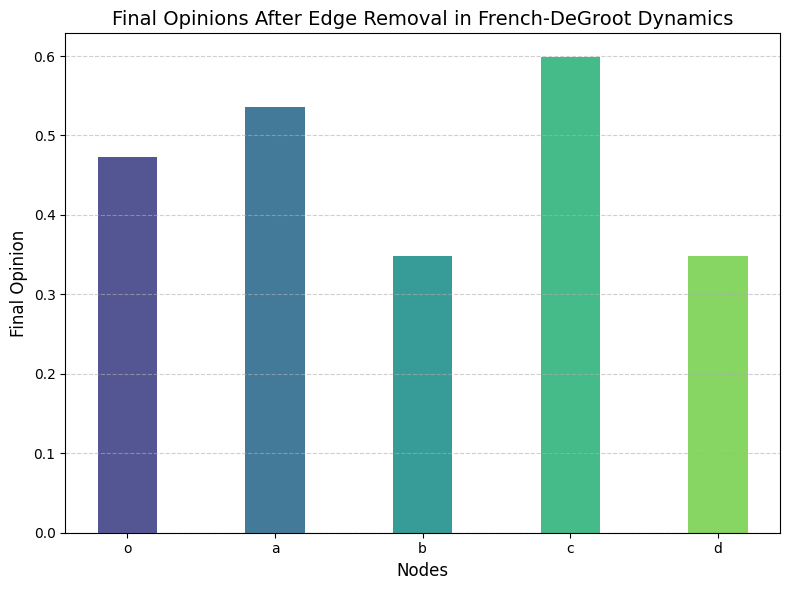

In [37]:
# plotting the final opinions after edge removal
nodes = ['o', 'a', 'b', 'c', 'd']

# Define a colormap for better visual distinction
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(nodes)))

plt.figure(figsize=(8, 6))
plt.bar(nodes, final_opinions_h, color=colors, width=0.4, alpha=0.9)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Final Opinion", fontsize=12)
plt.title("Final Opinions After Edge Removal in French-DeGroot Dynamics", fontsize=14)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('final_opinions_after_edge_removal_h.jpg', dpi=300)
plt.show()
